### RF in Sewer Pipes - Losses in Soil and Pipes

This notebook combines findings and conclusions from the other ones in order to estimate losses in dB per metre in pipes of various diameters, buried in different soils; as well as losses through the soil itself.

The pipes themselves are modelled as circular lossy waveguides. A couple of different soil types have been investigated to generate a representative sample. However, a more thorough investigation would require manually changing the soil type.

In [1]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from cycler import cycler

import aux_funcs
import itur_p527 as p527
import itur_p2040 as p2040
import circular_lossy_waveguide as clw
import circular_metal_waveguide as cmw

In [2]:
freqs = np.logspace(8, 12, 401)
freqs /= 1e9
pipe_diameters = np.logspace(-2, 1, 301)
temps = np.logspace(5, 25, 5, dtype='int')
water_vols = np.linspace(0.1, 0.9, 5)

In [3]:
test_soil = p527.SOILS['clay_loam']
test_water_vol = 0.9
test_temp = 10.0
test_soil_permittivity_pos = np.zeros(np.size(freqs), dtype=complex)
test_soil_permittivity_neg = np.zeros(np.size(freqs), dtype=complex)
test_soil_tan_delta_pos = np.zeros(np.size(freqs), dtype=float)
test_soil_tan_delta_neg = np.zeros(np.size(freqs), dtype=float)

for idx, freq in enumerate(freqs):
    foo = p527.soil_permittivity(freq, test_temp,test_soil.p_sand, test_soil.p_clay, test_soil.p_silt, test_water_vol)
    test_soil_permittivity_pos[idx] = foo
    test_soil_permittivity_neg[idx] = complex(foo.real, -foo.imag)
    test_soil_tan_delta_pos[idx] = aux_funcs.complex_permittivity_to_tan_delta(test_soil_permittivity_pos[idx].real, test_soil_permittivity_pos[idx].imag)
    test_soil_tan_delta_neg[idx] = aux_funcs.complex_permittivity_to_tan_delta(test_soil_permittivity_neg[idx].real, test_soil_permittivity_neg[idx].imag)

In [4]:
test_soil_attenuation_rate = np.zeros(np.size(freqs))
test_soil_tx_coeff_te = np.zeros(np.size(freqs))
test_soil_tx_coeff_tm = np.zeros(np.size(freqs))
test_soil_prop_const = np.zeros(np.size(freqs))

In [5]:
for idx, freq in enumerate(freqs):
    test_soil_attenuation_rate[idx] = p2040.material_attenuation_rate(freq, test_soil_permittivity_neg[idx].real, test_soil_tan_delta_neg[idx])
    
    foo = aux_funcs.plane_wave_prop_const(freq, test_soil_permittivity_neg[idx].real, test_soil_permittivity_neg[idx].imag, 1.0)
    test_soil_prop_const[idx] = aux_funcs.nepers_to_db(np.abs(foo[0]))

    foo_te = p2040.single_layer_slab_coefficients(freq, 1.0, test_soil_permittivity_neg[idx], 0.0, 'TE')
    foo_tm = p2040.single_layer_slab_coefficients(freq, 1.0, test_soil_permittivity_neg[idx], 0.0, 'TM')
    if foo_tm[1] == 0:
        test_soil_tx_coeff_tm[idx] = np.nan
    elif foo_te[1] == 0:
        test_soil_tx_coeff_te[idx] = np.nan
    else:
        test_soil_tx_coeff_te[idx] = 20*np.log10(np.abs(foo_te[1]))
        test_soil_tx_coeff_tm[idx] = 20*np.log10(np.abs(foo_tm[1]))


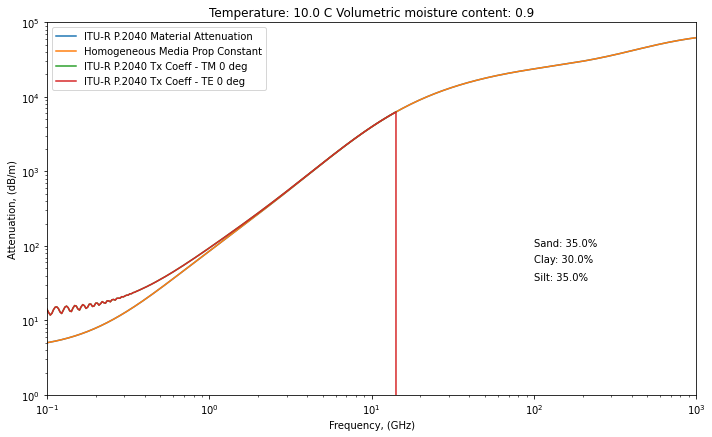

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10/1.618)

ax.loglog(freqs, test_soil_attenuation_rate, label='ITU-R P.2040 Material Attenuation')
ax.loglog(freqs, test_soil_prop_const, label='Homogeneous Media Prop Constant')
ax.loglog(freqs, -test_soil_tx_coeff_tm, label='ITU-R P.2040 Tx Coeff - TM 0 deg')
ax.loglog(freqs, -test_soil_tx_coeff_te, label='ITU-R P.2040 Tx Coeff - TE 0 deg')
ax.set_xlim(np.min(freqs), np.max(freqs))
ax.set_ylim(1, 1e5)

ax.set_xlabel('Frequency, (GHz)')
ax.set_ylabel('Attenuation, (dB/m)')

ax.legend()

ax.set_title(f'Temperature: {test_temp} C Volumetric moisture content: {test_water_vol}')

ax.text(1e2, 1.0e2, f'Sand: {test_soil.p_sand}%')
ax.text(1e2, 0.6e2, f'Clay: {test_soil.p_clay}%')
ax.text(1e2, 0.35e2, f'Silt: {test_soil.p_silt}%')

fig.tight_layout()

# fig.savefig('Clay Loam Losses mv 0.9.png', dpi=600, bbox_inches='tight')

In [7]:
soil_losses_p2040 = np.zeros((len(p527.SOILS), np.size(freqs)))
soil_losses_paper = np.zeros((len(p527.SOILS), np.size(freqs)))
soil_losses_slabs = np.zeros((len(p527.SOILS), np.size(freqs)))
soil_permittivity = np.zeros(np.size(freqs))
test_temp = 10
test_water_vol = 0.5

In [8]:
for i, soil in enumerate(p527.SOILS):
    test_soil = p527.SOILS[soil]
    for j, freq in enumerate(freqs):
        soil_permittivity = p527.soil_permittivity(freq, test_temp, test_soil.p_sand, test_soil.p_clay, test_soil.p_silt, test_water_vol)
        soil_loss_tangent = aux_funcs.complex_permittivity_to_tan_delta(soil_permittivity.real, soil_permittivity.imag)
        soil_losses_p2040[i, j] = p2040.material_attenuation_rate(freq, soil_permittivity.real, soil_loss_tangent)
        foo, _ = aux_funcs.plane_wave_prop_const(freq, soil_permittivity.real, soil_permittivity.imag, 1.0)
        soil_losses_paper[i, j] = aux_funcs.nepers_to_db(foo)

In [9]:
for i, soil in enumerate(p527.SOILS):
    test_soil = p527.SOILS[soil]
    for j, freq in enumerate(freqs):
        soil_permittivity = p527.soil_permittivity(freq, test_temp, test_soil.p_sand, test_soil.p_clay, test_soil.p_silt, test_water_vol)
        soil_perm_neg = complex(soil_permittivity.real, -soil_permittivity.imag)
        foo = p2040.single_layer_slab_coefficients(freq, 1.0, soil_perm_neg, 0, 'TE')
        if foo[1] == 0.0:
            soil_losses_slabs[i, j] = np.nan
        else:
            soil_losses_slabs[i, j] = 20 * np.log10(np.abs(foo[1]))

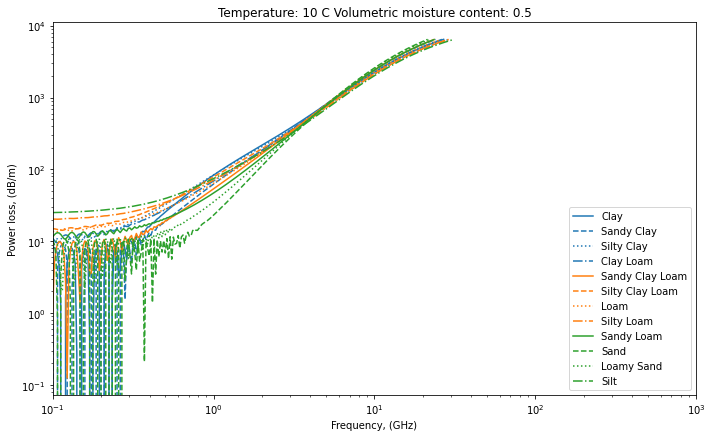

In [10]:
custom_cycler = (cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]) * cycler(linestyle=['-', '--', ':', '-.']))
fig, ax = plt.subplots()
ax.set_prop_cycle(custom_cycler)
color_idx = np.linspace(0, 1, len(p527.SOILS))
fig.set_size_inches(10, 10/1.618)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(np.min(freqs), np.max(freqs))
#ax.set_ylim(1, 14)
#ax.set_yticks([1, 2, 4, 6, 8, 10, 12, 14])
#ax.set_yticklabels([1, 2, 4, 6, 8, 10, 12, 14])
for i, soil in enumerate(p527.SOILS):
#    print(soil)
    ax.plot(freqs, -soil_losses_slabs[i, :], label=soil.replace('_', ' ').title())
ax.set_xlabel('Frequency, (GHz)')
ax.set_ylabel('Power loss, (dB/m)')
ax.set_title(f'Temperature: {test_temp} C Volumetric moisture content: {test_water_vol}')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f'Line Plot Fixed Temperature - {test_temp} Fixed mv - {test_water_vol}.png', dpi=600, bbox_inches='tight')

In [11]:
test_soil = p527.SOILS['clay_loam']
test_soil_temp = 10.0
test_soil_water_vol = 0.5
test_soil_er = np.zeros(np.size(freqs), dtype=complex)
test_soil_tan_delta = np.zeros(np.size(freqs))

for idx, freq in enumerate(freqs):
    foo = p527.soil_permittivity(freq, test_soil_temp, test_soil.p_sand, test_soil.p_clay, test_soil.p_silt, test_soil_water_vol)
    test_soil_er[idx] = complex(foo.real, -foo.imag)
    test_soil_tan_delta[idx] = aux_funcs.complex_permittivity_to_tan_delta(foo.real, foo.imag)

In [12]:
loss_p2040 = np.zeros((np.size(freqs), np.size(pipe_diameters)))
loss_clw = np.zeros((np.size(freqs), np.size(pipe_diameters)))
loss_cmw = np.zeros((np.size(freqs), np.size(pipe_diameters)))

In [13]:
for i, freq in enumerate(freqs):
    for j, diameter in enumerate(pipe_diameters):
        loss_p2040[i, j] = p2040.dielectric_wvg_loss(freq, diameter, diameter, test_soil_er[i].real, np.abs(test_soil_er[i].imag), 'vertical', 'circle')

In [14]:
for i, freq in enumerate(freqs):
    for j, diameter in enumerate(pipe_diameters):
        foo = clw.calc_attenuation_constant(freq, diameter, test_soil_er[i], 'HE', 1, 1)
        loss_clw[i, j] = aux_funcs.nepers_to_db(foo) 

In [15]:
xv, yv = np.meshgrid(freqs, pipe_diameters, indexing='ij')

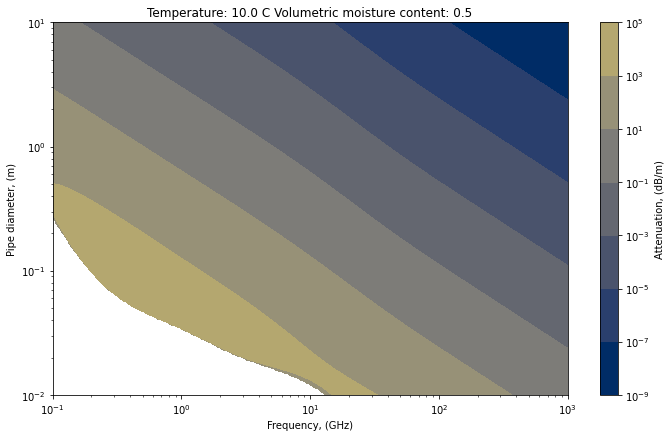

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10/1.618)

ax.set_xscale('log')
ax.set_yscale('log')

contour = ax.contourf(xv, yv, loss_p2040, cmap='cividis', norm=colors.LogNorm(vmin=1e-9, vmax=1e9))

ax.set_xlabel('Frequency, (GHz)')
ax.set_ylabel('Pipe diameter, (m)')
ax.set_title(f'Temperature: {test_soil_temp} C Volumetric moisture content: {test_soil_water_vol}')

fig.tight_layout()

cbar = fig.colorbar(contour)
cbar.set_label('Attenuation, (dB/m)')

# fig.savefig('Clay Loam P2040.png', dpi=600, bbox_inches='tight')

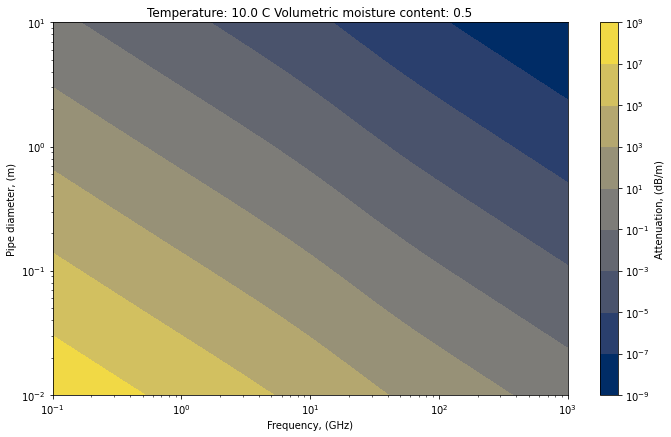

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10/1.618)

ax.set_xscale('log')
ax.set_yscale('log')

contour = ax.contourf(xv, yv, loss_clw, cmap='cividis', norm=colors.LogNorm(vmin=1e-9, vmax=1e9))

ax.set_xlabel('Frequency, (GHz)')
ax.set_ylabel('Pipe diameter, (m)')
ax.set_title(f'Temperature: {test_soil_temp} C Volumetric moisture content: {test_soil_water_vol}')

fig.tight_layout()

cbar = fig.colorbar(contour)
cbar.set_label('Attenuation, (dB/m)')

# fig.savefig('Clay Loam Paper.png', dpi=600, bbox_inches='tight')

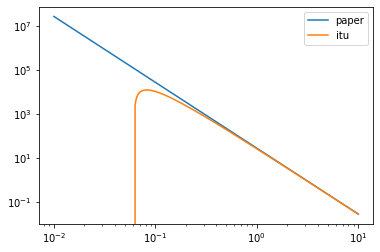

In [18]:
plt.loglog(pipe_diameters, loss_clw[50, :], label='paper')
plt.loglog(pipe_diameters, loss_p2040[50, :], label='itu')
plt.legend()